<a href="https://colab.research.google.com/github/PritamKhaire/LangTranslator/blob/main/DeepNN_Language_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=188544a8029e7ac29b384007580ad7e3ce2e761923cd762747348173ab8d831d
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  |     Proc size: 118.1 MB
GPU RAM Free: 7611MB | Used: 0MB | Util   0% | Total     7611MB


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)
# if device_name != '/device:GPU:0':                                                    
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


In [57]:
import pandas as pd
import numpy as np
import os
import re
import string
import unicodedata
from sklearn.model_selection import train_test_split

In [4]:
FILE_PATH = "./drive/MyDrive/Drive_data/mar.txt"

In [5]:
lines = pd.read_table(FILE_PATH, encoding='utf-8', names = ['eng', 'mar'])

In [6]:
lines.head()

,eng,mar
Go.,जा.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Run!,पळ!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
Run!,धाव!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
Run!,पळा!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
Run!,धावा!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [7]:
lines["english"] = lines.index
lines["marathi"] = lines.eng

lines.drop(["eng", "mar"], axis = 1, inplace = True)
lines = lines.reset_index(drop = True)

In [8]:
lines.head()

,english,marathi
0,Go.,जा.
1,Run!,पळ!
2,Run!,धाव!
3,Run!,पळा!
4,Run!,धावा!


In [9]:
def unicode_to_ascii(sentence):
  return "".join(c for c in unicodedata.normalize('NFD', sentence) if unicodedata.category(c) != 'Mn')

In [10]:
def preprocessing(sentence, language = False):
  sentence = unicode_to_ascii(sentence.lower().strip())

  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+ ', " ", sentence )
  sentence = re.sub(r"'", r'', sentence)
  
  exclude = set(string.punctuation)
  remove_digits = str.maketrans('', '', string.digits)
  sentence = "".join(ch for ch in sentence if ch not in exclude)
  sentence = sentence.translate(remove_digits)

  sentence = re.sub(r"[२३०८१५७९४६]", "", sentence)
  sentence = re.sub(r" +", r" ", sentence)
  sentence = sentence.strip()
  if language:
    sentence = '<START>' + sentence + "<END>"
  return sentence

In [11]:
def create_dataset(file_name):
  file_name.english = file_name.english.apply(lambda x : preprocessing(x, False))
  file_name.marathi = file_name.marathi.apply(lambda x : preprocessing(x, True))
  return file_name.english, file_name.marathi

In [12]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding="post")
  return tensor, lang_tokenizer

In [13]:
def load_dataset(lines):
  target_lang, input_lang = create_dataset(lines)
  input_tensor, inp_lang_tokenizer = tokenize(input_lang)
  target_tensor, targ_lang_tokenizer = tokenize(target_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [14]:
input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer = load_dataset(lines)

In [15]:
# MAX_LENGTH_INPUT = input_tensor.shape[1]
# MAX_LENGTH_TARGET = target_tensor.shape[1]

In [16]:
# INPUT_VOCAB_SIZE = len(inp_lang_tokenizer.word_index) + 1
# TARGET_VOCAB_SIZE = len(targ_lang_tokenizer.word_index) + 1

In [19]:
# INPUT_VOCAB_SIZE, TARGET_VOCAB_SIZE

In [18]:
input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size = 0.2)

In [66]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print(f'{t} ------> {lang.index_word[t]}')

In [67]:
print("Input language: Index to word mapping...")
convert(inp_lang_tokenizer, input_tensor_train[0])
print("Target Language; index to word mapping")
convert(targ_lang_tokenizer, target_tensor_train[0])

Input language: Index to word mapping...
6 ------> <start>मला
4199 ------> मतयची
883 ------> भीती
13 ------> नाहीय<end>
Target Language; index to word mapping
1 ------> i
19 ------> dont
2023 ------> fear
998 ------> death


In [20]:
MAX_LENGTH_INPUT = input_tensor_train.shape[1]
MAX_LENGTH_TARGET = target_tensor_train.shape[1]

INPUT_VOCAB_SIZE = len(inp_lang_tokenizer.word_index) + 1
TARGET_VOCAB_SIZE = len(targ_lang_tokenizer.word_index) + 1

In [59]:
print("MAX_LENGTH_INPUT....", MAX_LENGTH_INPUT)
print('MAX_LENGTH_TARGET...', MAX_LENGTH_TARGET)
print("INPUT_VOCAB_SIZE....", INPUT_VOCAB_SIZE)
print("TARGET_VOCAB_SIZE....", TARGET_VOCAB_SIZE)

MAX_LENGTH_INPUT.... 35
MAX_LENGTH_TARGET... 34
INPUT_VOCAB_SIZE.... 15910
TARGET_VOCAB_SIZE.... 5695


In [21]:
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [22]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Concatenate
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
LATENT_DIM = 256

In [24]:
encoder_input = Input(shape=(MAX_LENGTH_INPUT, ))
encoder_embedding = Embedding(INPUT_VOCAB_SIZE, LATENT_DIM, trainable = True)(encoder_input)

In [25]:
encoder_lstm_1 = LSTM(LATENT_DIM, 
                      return_sequences=True, 
                      return_state=True)
encoder_output_1, encoder_h_1, encoder_c_1 = encoder_lstm_1(encoder_embedding)

In [26]:
encoder_lstm_2 = LSTM(LATENT_DIM, 
                      return_state = True,
                      return_sequences = True)
encoder_output2, encoder_h_2, encoder_c_2 = encoder_lstm_2(encoder_output_1)

In [27]:
encoder_lstm_3 = LSTM(LATENT_DIM,
                       return_state = True,
                       return_sequences = True)
encoder_output, encoder_h, encoder_c = encoder_lstm_3(encoder_output2)

In [28]:
# Set up decoder
decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(TARGET_VOCAB_SIZE, LATENT_DIM, trainable = True)(decoder_input)

In [29]:
decoder_lstm = LSTM(LATENT_DIM,
                    return_sequences = True,
                    return_state = True)
decoder_output, decoder_forward_state, decoder_backword_state = decoder_lstm(decoder_embedding, initial_state = [encoder_h, encoder_c])

In [30]:
attention_layer = AttentionLayer()
attention_output, attention_state = attention_layer([encoder_output, decoder_output])

In [31]:
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_output, attention_output])
decoder_dense = TimeDistributed(Dense(TARGET_VOCAB_SIZE, activation = 'softmax'))
decoder_output = decoder_dense(decoder_concat_input)

In [32]:
# Define model
model = Model([encoder_input, decoder_input], decoder_output)

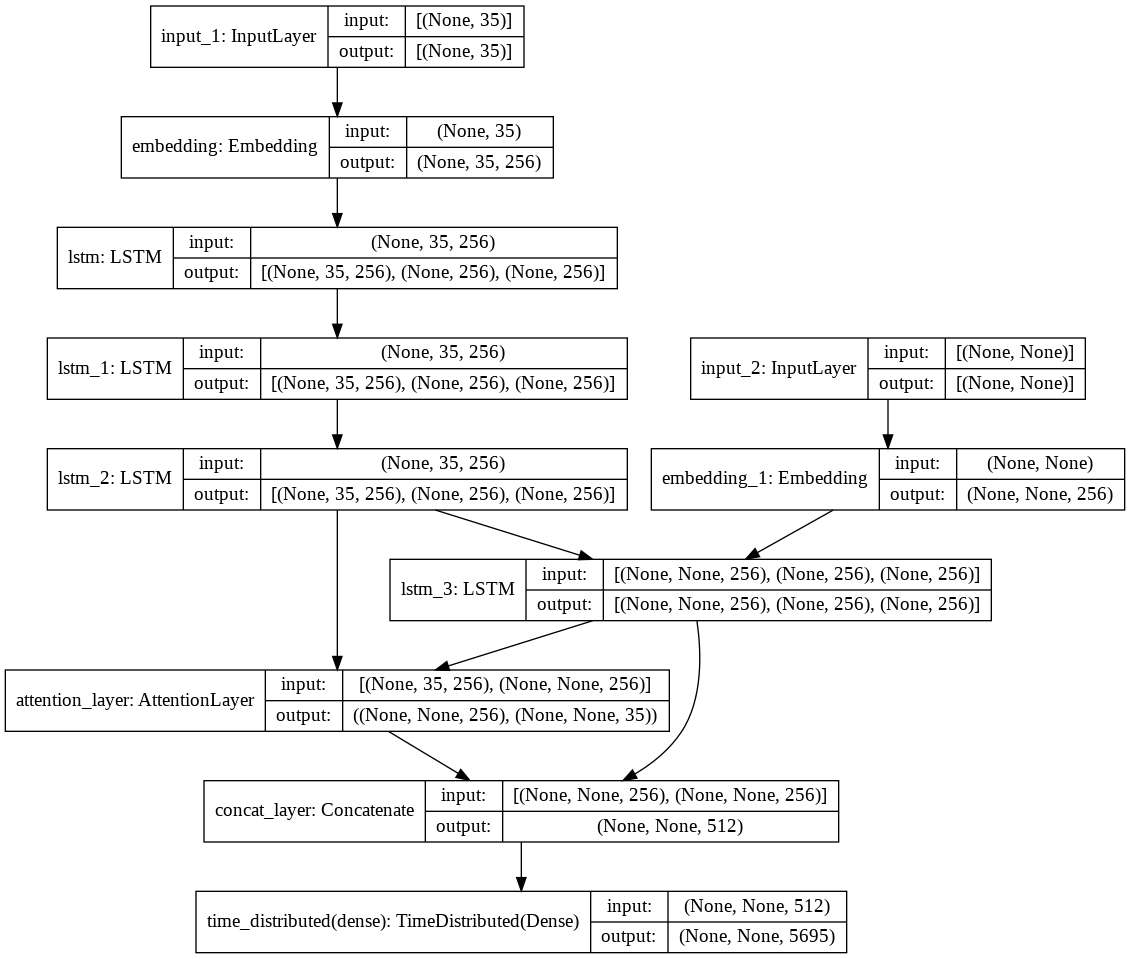

In [33]:
plot_model(model, show_shapes = True, to_file = "training_model.png")

In [34]:
optimizer = tf.keras.optimizers.Adam()
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
#                                                             reduction = 'none')

# def loss_function(real, pred):
#   mask = tf.math.logical_not(tf.math.equal(real, 0))
#   loss_ = loss_object(real, pred)
#   mask = tf.cast(mask, dtype=loss_.dtype)
#   loss_ *= mask
#   return tf.reduce_mean(loss_)

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [36]:
model.compile(optimizer=optimizer, loss="SparseCategoricalCrossentropy", metrics = ["accuracy"])

In [ ]:
history = model.fit([input_tensor_train, target_tensor_train[:, :-1]], target_tensor_train.reshape(target_tensor_train.shape[0], target_tensor_train.shape[1], 1)[:, 1:],
                    epochs = 50,
                    callbacks = [es],
                    batch_size = 512,
                    validation_data = ([input_tensor_test, target_tensor_test[:, :-1]], target_tensor_test.reshape(target_tensor_test.shape[0], target_tensor_test.shape[1], 1)[:, 1:]))

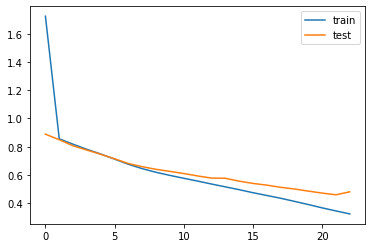

In [38]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [39]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [40]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")

In [72]:
print(model_loaded.input[0])
print( model_loaded.layers[6].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 35), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
[<KerasTensor: shape=(None, 35, 256) dtype=float32 (created by layer 'lstm_2')>, <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_2')>, <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_2')>]


In [83]:
#inference

latent_dim=256
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs
#print(encoder_outputs.shape)
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(MAX_LENGTH_INPUT,latent_dim))
# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output
#print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [105]:
def decode_sequence(input_seq):
    print("Input seqeunce...", input_seq)
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Mword2index['start']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Sample a token
        print("output_token..", output_tokens)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
		
        if sampled_token_index == 0:
          break
        else:
          sampled_token = Mindex2word[sampled_token_index]
        decoded_sentence += ' '+ sampled_token
        
        if (sampled_token == '<end>' or
              len(decoded_sentence) > len(decoded_sentence.split()) >= (26-1)):
                stop_condition = True
          
                # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update internal states
        e_h, e_c = h, c
    print("Decoded sequenced...", decoded_sentence)
    return decoded_sentence

In [106]:
Eindex2word = inp_lang_tokenizer.index_word
Mindex2word = targ_lang_tokenizer.index_word
Mword2index = targ_lang_tokenizer.word_index

In [107]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Mword2index['start']) and i!=Mword2index['end']):
        newString=newString+Mindex2word[i]+' '
    return newString
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString + Eindex2word[i]+' '
    return newString

In [108]:
for i in range(10):  
  print("Review:",seq2text(input_tensor_test[i]))
  print("Original summary:",seq2summary(target_tensor_test[i]))
  print("Predicted summary:",decode_sequence(input_tensor_test[i].reshape(1,MAX_LENGTH_INPUT)))
  print("\n")

Review: <start>मी बल बघायला गल<end> 
Original summary: i went to see the ballet 
Input seqeunce... [[   2 3595  399  166    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
output_token.. [[[6.0118609e-06 2.6599264e-05 9.1053062e-06 ... 9.0692328e-07
   1.7344939e-09 2.6568305e-09]]]
output_token.. [[[7.9266538e-05 3.0536994e-05 6.1204380e-05 ... 4.4919886e-08
   2.5551952e-08 2.7246381e-08]]]
output_token.. [[[1.99307715e-06 3.12453693e-07 1.01506316e-07 ... 7.25860216e-09
   4.01593951e-07 3.02445983e-07]]]
output_token.. [[[9.9851722e-01 1.0906317e-05 1.1753267e-05 ... 2.0820666e-10
   8.5662029e-09 1.2471997e-09]]]
Decoded sequenced...  in the room
Predicted summary:  in the room


Review: <start>तया मरताहत<end> 
Original summary: theyre dying 
Input seqeunce... [[  28 6141    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0 

In [96]:
input_value = [ 237, 2361, 1887,   32,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     0,    0,    0,    0,    0,    0,    0]

In [95]:
input_tensor_train[0]

array([   6, 4199,  883,   13,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [100]:
print("Input language: Index to word mapping...")
convert(inp_lang_tokenizer, input_value)
print("Target Language; index to word mapping")
convert(targ_lang_tokenizer, input_value)

Input language: Index to word mapping...
237 ------> <start>तमच
2361 ------> करडिट
1887 ------> कारड
32 ------> कठ
10 ------> आहत<end>
Target Language; index to word mapping
237 ------> mine
2361 ------> boiled
1887 ------> packed
32 ------> know
10 ------> do
